# Deep Fashion 2 clothing matching

The main purpose of this notebook is to facilitate the creation of Triplet Examples for clothing matching.

In [19]:
from typing import List
import itertools
import random

import skimage.io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from masks import get_mask
from data_loader import load_training_df

pd.set_option('display.max_columns', None)

In [20]:
dataset_path = 'dataset'

## Read dataset

Read images and annotations in training.

In [21]:
df = load_training_df(dataset_path)

Map ordinal categories (e.g. scale, occlusion and viewpoint) into categorical columns for better understanding (values according to documentation).

In [22]:
df['scale_categorical'] = df['scale'].map(
    {1: 'small_scale', 2: 'modest_scale', 3: 'large_scale'}
)
df['zoom_in_categorical'] = df['zoom_in'].map(
    {1: 'no_zoom_in', 2: 'medium_zoom_in', 3: 'large_zoom_in'}
)
df['viewpoint_categorical'] = df['viewpoint'].map(
    {1: 'no_wear', 2: 'frontal_viewpoint', 3: 'side_or_back_viewpoint'}
)
df['occlusion_categorical'] = df['occlusion'].map(
    {1: 'slight_occlusion', 2: 'medium_occlusion', 3: 'heavy_occlusion'}
)

Let's visualize some examples.

In [23]:
df.sample(3)

,segmentation,scale,viewpoint,zoom_in,landmarks,style,bounding_box,category_id,occlusion,category_name,source,pair_id,image_path,scale_categorical,zoom_in_categorical,viewpoint_categorical,occlusion_categorical
id,,,,,,,,,,,,,,,,,
82267,"[[421, 389, 365, 399, 300, 392, 259, 538, 224,...",2,3,1,"[421, 389, 2, 365, 399, 2, 300, 392, 2, 477, 5...",1,"[211, 372, 516, 785]",9,1,skirt,shop,6495,dataset/train/image/082267.jpg,modest_scale,no_zoom_in,side_or_back_viewpoint,slight_occlusion
145386,"[[219, 487, 278, 510, 349, 514, 338, 603, 303,...",1,2,1,"[219, 487, 1, 278, 510, 1, 349, 514, 1, 175, 5...",0,"[162, 479, 352, 725]",9,2,skirt,shop,11399,dataset/train/image/145386.jpg,small_scale,no_zoom_in,frontal_viewpoint,medium_occlusion
61302,"[[330, 515, 232, 564, 132, 526, 143, 592, 158,...",2,2,2,"[132, 526, 1, 232, 564, 2, 330, 515, 1, 143, 5...",0,"[125, 498, 336, 650]",7,1,shorts,user,4850,dataset/train/image/061302.jpg,modest_scale,medium_zoom_in,frontal_viewpoint,slight_occlusion


Let's map categories into supercategories.

In [31]:
supercategory_map = {
    'short sleeve top': 'top',
    'long sleeve dress': 'dress',
    'trousers': 'trousers',
    'long sleeve top': 'top',
    'skirt': 'skirt',
    'shorts': 'shorts',
    'long sleeve outwear': 'outwear',
    'vest dress': 'dress',
    'short sleeve dress': 'dress',
    'vest': 'top',
    'sling dress': 'dress',
    'short sleeve outwear': 'outwear',
    'sling': 'top'
}

df['supercategory_name'] = df['category_name'].map(supercategory_map)

# Build pairs

## Positive pairs

We build a set of positive pairs, so:

- Positive pairs have same `pair_id`.
- Positive pairs have same `category_id`.
- Positive pairs have different `image_path`.

In [33]:
pairing_cols = ['pair_id', 'category_name', 'category_id', 'supercategory_name']


def _matching_pairs(match_df: pd.DataFrame,
                    max_samples_per_match: int = 10,
                    max_match_pool: int = 100) -> pd.DataFrame:
    if len(match_df) < 2:
        return pd.DataFrame()
    
    # Create random subset of pairs
    positions = range(len(match_df))
    idx_pairs = list(itertools.combinations(positions, 2))
    random.shuffle(idx_pairs)

    # Select random subset of potential matches
    idx_pairs = idx_pairs[:max_match_pool]
    
    # Create two dataframes using pairs
    idx_pairs_x, idx_pairs_y = list(zip(*idx_pairs))
    x_df = match_df.iloc[np.array(idx_pairs_x)]
    y_df = match_df.iloc[np.array(idx_pairs_y)]
    pairs_df = x_df.merge(y_df, on=pairing_cols, suffixes=('_1', '_2'))
    
    # Return subset of pairs using different images
    diff_image_pairs_df = pairs_df[
        pairs_df['image_path_1'] != pairs_df['image_path_2']
    ]
    samples_to_take = min(len(diff_image_pairs_df), max_samples_per_match)
    return diff_image_pairs_df.sample(samples_to_take)

positive_pairs = df.groupby(pairing_cols)\
                   .apply(_matching_pairs)\
                   .reset_index(drop=True)

In [34]:
print(f'Created positive {len(positive_pairs)} pairs')

Created positive 264735 pairs


Visualize positive pair examples.

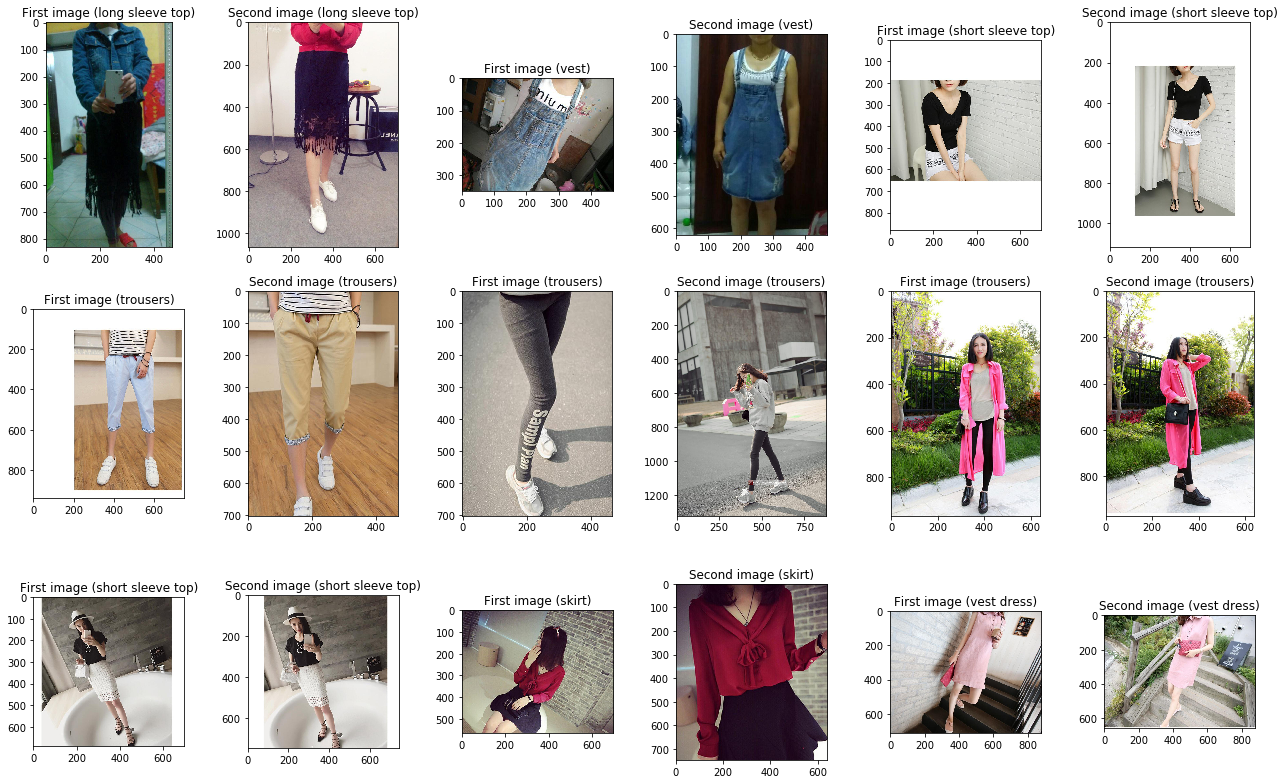

In [36]:
def display_pairs(df: pd.DataFrame,
                  n_cols=3,
                  **display_args):
    n = len(df)
    n_rows = int(np.ceil(n/n_cols))
    
    # Estimate figsize
    figsize = (3*n_cols * 2, 3.75*n_rows)
    fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=figsize)
    
    for i in range(n):
        # Locate sample in grid
        row = df.iloc[i]
        i_idx, j_idx = np.unravel_index(i, (n_rows, n_cols))

        # Display first example
        ax = axes[i_idx][j_idx * 2]
        ax.imshow(skimage.io.imread(row.image_path_1))
        ax.set_title(f'First image ({row.category_name})')
        
        # Display second image
        ax = axes[i_idx][(j_idx * 2) + 1]
        ax.imshow(skimage.io.imread(row.image_path_2))
        ax.set_title(f'Second image ({row.category_name})')

    fig.tight_layout()

display_pairs(positive_pairs.sample(9))

In [38]:
positive_pairs.to_csv('positive_pairs.csv')

## Create triplet from positive example

The idea is to generate as many negative pairs as positive pairs. In order to generate "hard negatives", we are going to collect pairs which belong to the same category (we assume it is easier to distinguish between a dress and a shirt than to distinguish between two shirts).

Let's first define the categories which we think are confusing to one another (this is a bijective function).

Negative example $N$ for a pair $P = \{p_1, p_2\}$ example that:

- Its `pair_id` differs from the pair id from $P$.
- Its `image_path` its non overlapping with pats from $P$.
- It belongs to the same supercategory as category in $P$.

In [ ]:
TODO: find a way to do it without taking so long

In [37]:
def _sample_negative_example(positive_pair: pd.Series) -> pd.Series:
    return df[
        (df.supercategory_name == positive_pair.supercategory_name) &
        (df.pair_id != positive_pair.pair_id) &
        (df.image_path != positive_pair.image_path_1) &
        (df.image_path != positive_pair.image_path_2)
    ].sample(1).iloc[0]

negative_samples = positive_pairs.apply(_sample_negative_example, axis=1)

KeyboardInterrupt: 

## Clothing elements per image: stats

In [ ]:
clothes_per_image = df.groupby('image_path')['category_id'].count()
mean, std = clothes_per_image.mean(), clothes_per_image.std()
print(f'Clothes per image: {mean:.2f} +- {std:.2f}')

## Mask generation

Compute mask image from examples.

In [ ]:
def _display_masks(image: np.ndarray, masks: List, ax=None):
    # Display image
    if ax is not None:
        axis = ax
    else:
        plt.figure(figsize=(8, 15))
        axis = plt
    axis.imshow(image)
    
    # Display all masks
    for mask in masks:
        axis.imshow(mask, alpha=0.25, vmin=-1.0, vmax=1.0)

        
def instance_to_mask(row: pd.Series) -> np.ndarray:
    image = skimage.io.imread(row['image_path'])
    image_height, image_width = image.shape[:2]
    return get_mask(image_height,
                    image_width,
                    polygons=row['segmentation'],
                    category_id=int(row['category_id']))


def display_instance_mask(row: pd.Series, ax) -> None:
    masks = [instance_to_mask(row)]
    image = skimage.io.imread(row['image_path'])
    _display_masks(image, masks, ax=ax)
    ax.set_title(row["category_name"])
    ax.axis('off')
    
samples = df.sample(12)
display_instances(samples, display_fn=display_instance_mask, n_cols=6)

We see that, in many cases, polygons defining the clothing area are quite sharp and do not properly wrap the clothes margin.

Let's now visualize examples of images with all masks in it.

In [ ]:
def display_all_instance_masks(row: pd.Series, ax) -> None:
    items = df[df.index == row.name]
    masks = items.apply(instance_to_mask, axis=1).values.tolist()
    image = skimage.io.imread(row['image_path'])
    _display_masks(image, masks, ax=ax)
    # Displau call categories
    categories = items["category_name"].values.tolist()
    ax.set_title(f'{categories}', fontsize=8)
    ax.axis('off')

samples = df.sample(12)
display_instances(samples, display_fn=display_all_instance_masks, n_cols=6)